# ResNet50

In [1]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    Dropout
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay,classification_report,precision_score,recall_score,f1_score
import time
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [3]:
def matrix_confusion(yt, yp,time_taken):
    data = {'Y_Real': yt,
            'Y_Pred': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Pred'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Pred'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()
    y_val = df['Y_Real'].to_numpy()
    predictions = df['Y_Pred'].to_numpy()
    accuracy = accuracy_score(y_val,predictions)
    precision = precision_score(y_val,predictions)
    recall = recall_score(y_val,predictions)
    f1 = f1_score(y_val,predictions)
    print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Total Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    print("Classification Report:\n")
    print(classification_report(y_val,predictions))


    return time_taken,accuracy,precision,recall,f1

In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize your images as required
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

In [6]:
dataset = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/train', transform=transform)

In [7]:
def calculate_channel_stats(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    total_samples = 0
    mean = torch.zeros(3)  # Initialize mean for RGB channels
    std = torch.zeros(3)   # Initialize standard deviation for RGB channels
    
    for data, _ in loader:
        img = data.squeeze(0)  # Remove batch dimension (assuming batch_size=1)
        mean += torch.mean(img, dim=(1, 2))  # Compute mean along height and width dimensions
        std += torch.std(img, dim=(1, 2))    # Compute standard deviation along height and width dimensions
        total_samples += 1

    return mean / total_samples, std / total_samples

# Calculate mean and standard deviation for each channel
calculated_mean, calculated_std = calculate_channel_stats(dataset)
print("Calculated Mean for R, G, B channels:", calculated_mean)
print("Calculated Standard Deviation for R, G, B channels:", calculated_std)

Calculated Mean for R, G, B channels: tensor([0.4801, 0.4801, 0.4801])
Calculated Standard Deviation for R, G, B channels: tensor([0.2217, 0.2217, 0.2217])


In [8]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(calculated_mean, calculated_std),
])

In [9]:
train_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/train', transform=transform)
test_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/test', transform=transform)
valid_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/valid', transform=transform)

In [10]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [11]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=8)
test_loader = DataLoader(valid_data, shuffle=True, batch_size=1)
hold_out_test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [12]:
# Normal (0) and True, Pneumonia (1)
print((train_loader.dataset.class_to_idx))
print((test_loader.dataset.class_to_idx))
print((hold_out_test_loader.dataset.class_to_idx))

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


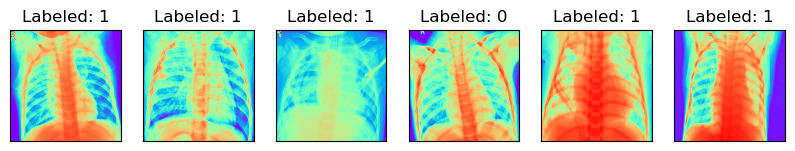

In [13]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\rjuya/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.3MB/s]


In [15]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2) # 2 classes
)
model = model.to('cuda')
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [17]:
epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/ResNet50 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


toc = time.time()

Training [6%]	Loss: 0.3123	Accuracy: 86.71%
Saving model with test loss of 90.728
Training [12%]	Loss: 0.2346	Accuracy: 90.73%
Training [19%]	Loss: 0.2222	Accuracy: 90.90%
Saving model with test loss of 91.832
Training [25%]	Loss: 0.2153	Accuracy: 91.83%
Saving model with test loss of 90.949
Training [31%]	Loss: 0.2156	Accuracy: 90.95%
Training [38%]	Loss: 0.2143	Accuracy: 91.22%
Saving model with test loss of 91.979
Training [44%]	Loss: 0.2002	Accuracy: 91.98%
Saving model with test loss of 91.415
Training [50%]	Loss: 0.2170	Accuracy: 91.42%
Training [56%]	Loss: 0.1986	Accuracy: 91.86%
Saving model with test loss of 92.176
Training [62%]	Loss: 0.2014	Accuracy: 92.18%
Training [69%]	Loss: 0.1900	Accuracy: 92.35%
Saving model with test loss of 91.710
Training [75%]	Loss: 0.2014	Accuracy: 91.71%
Saving model with test loss of 91.979
Training [81%]	Loss: 0.1896	Accuracy: 91.98%
Training [88%]	Loss: 0.2027	Accuracy: 92.00%
Saving model with test loss of 92.396
Training [94%]	Loss: 0.1863	A

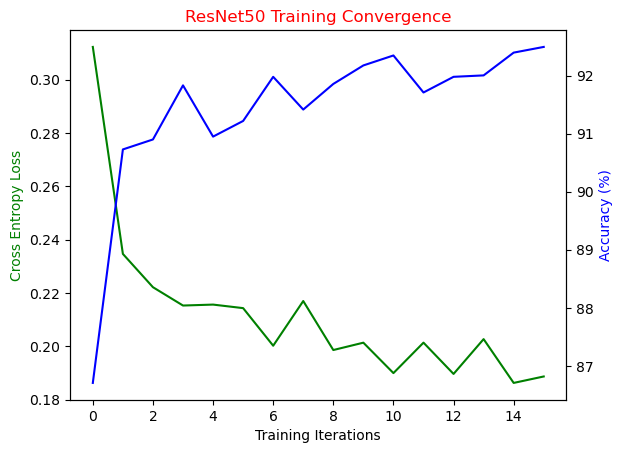

In [18]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("ResNet50 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [19]:
torch.save(model.state_dict(), model_path2)

In [20]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_temp.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2) # 2 classes
)
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [21]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.1386
	Accuracy: 95.71%
[1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,

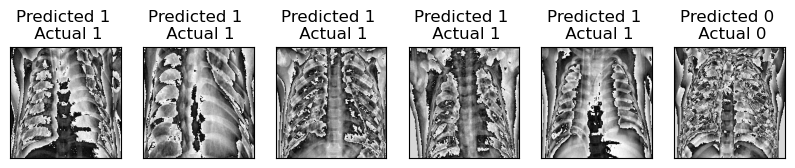

In [22]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [23]:
time_taken = toc-tic

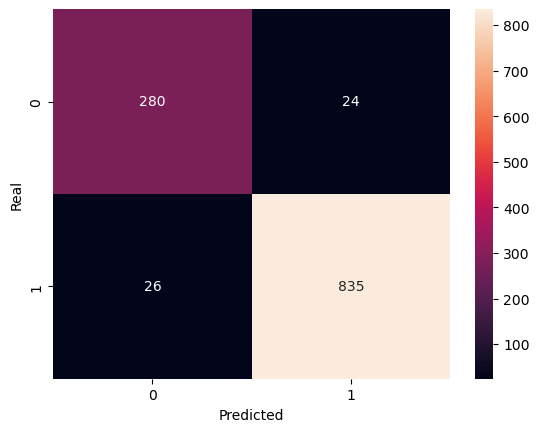

Time taken:  589.9776899814606
Test size: 1165
Total Accuracy:  0.9570815450643777
Total Precision:  0.9720605355064028
Total Recall:  0.9698025551684089
Total F1 Score:  0.9709302325581395
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       304
           1       0.97      0.97      0.97       861

    accuracy                           0.96      1165
   macro avg       0.94      0.95      0.94      1165
weighted avg       0.96      0.96      0.96      1165



In [24]:
valres = matrix_confusion(test_targets, pred_targets,time_taken)

In [25]:
out = pd.DataFrame([valres],
                   index = ['ResNet50 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
ResNet50 Model,589.97769,0.957082,0.972061,0.969803,0.97093


In [26]:
import pickle

In [27]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/ResNet50.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# GoogLeNet

In [28]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2) # 2 classes
)
model = model.to('cuda')
print(model.fc)

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [31]:
epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/googlenet model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


toc = time.time()

Training [6%]	Loss: 0.3328	Accuracy: 85.31%
Saving model with test loss of 89.355
Training [12%]	Loss: 0.2564	Accuracy: 89.35%
Training [19%]	Loss: 0.2560	Accuracy: 89.06%
Saving model with test loss of 90.189
Training [25%]	Loss: 0.2296	Accuracy: 90.19%
Saving model with test loss of 91.047
Training [31%]	Loss: 0.2261	Accuracy: 91.05%
Training [38%]	Loss: 0.2204	Accuracy: 91.07%
Saving model with test loss of 90.925
Training [44%]	Loss: 0.2223	Accuracy: 90.92%
Saving model with test loss of 90.557
Training [50%]	Loss: 0.2259	Accuracy: 90.56%
Training [56%]	Loss: 0.2171	Accuracy: 91.88%
Saving model with test loss of 91.317
Training [62%]	Loss: 0.2197	Accuracy: 91.32%
Training [69%]	Loss: 0.2204	Accuracy: 91.61%
Saving model with test loss of 91.195
Training [75%]	Loss: 0.2172	Accuracy: 91.19%
Saving model with test loss of 92.176
Training [81%]	Loss: 0.2033	Accuracy: 92.18%
Training [88%]	Loss: 0.2069	Accuracy: 91.88%
Saving model with test loss of 92.323
Training [94%]	Loss: 0.2077	A

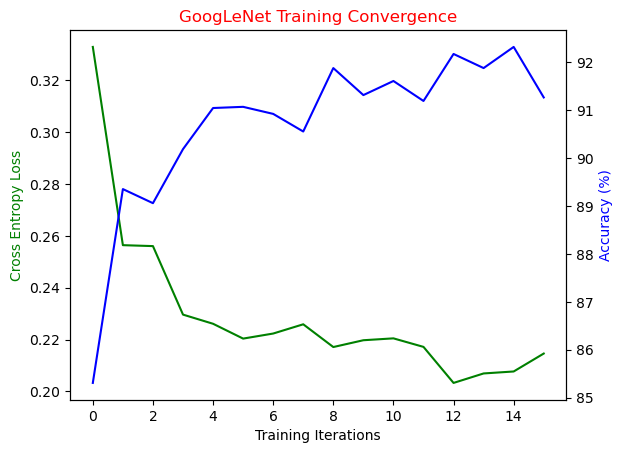

In [32]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("GoogLeNet Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [33]:
torch.save(model.state_dict(), model_path2)

In [34]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_temp.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2) # 2 classes
)
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [35]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.1636
	Accuracy: 95.11%
[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,

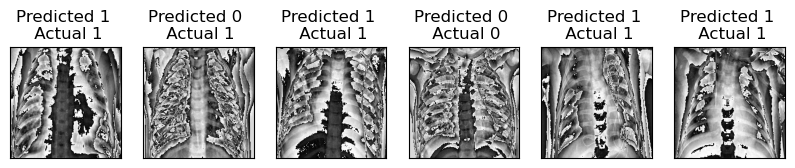

In [36]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [37]:
time_taken = toc-tic

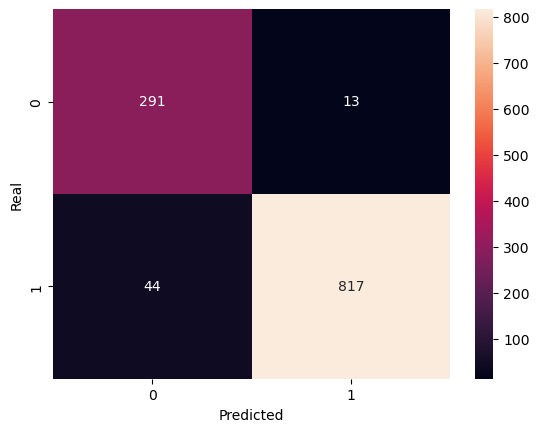

Time taken:  578.404566526413
Test size: 1165
Total Accuracy:  0.9510729613733906
Total Precision:  0.9843373493975903
Total Recall:  0.9488966318234611
Total F1 Score:  0.9662921348314606
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       304
           1       0.98      0.95      0.97       861

    accuracy                           0.95      1165
   macro avg       0.93      0.95      0.94      1165
weighted avg       0.95      0.95      0.95      1165



In [38]:
valgoog = matrix_confusion(test_targets, pred_targets,time_taken)

In [39]:
out = pd.DataFrame([valgoog],
                   index = ['GoogLeNet Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
GoogLeNet Model,578.404567,0.951073,0.984337,0.948897,0.966292


In [40]:
import pickle

In [41]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/googlenet.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# VGG19

In [42]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.classifier)
classifier_indices = [i for i, layer in enumerate(model.classifier) if isinstance(layer, Linear)]
last_fc_index = classifier_indices[-1] if classifier_indices else None

# Define your custom model head
n_inputs = model.classifier[last_fc_index].in_features  # Number of input features for your new layers
modelhead = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2)  # 2 classes in the final output layer
)
model.classifier = Sequential(
        *list(model.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    )
    
print(model)
model = model.to('cuda')


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

In [44]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [45]:
epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/vgg19 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


toc = time.time()

Training [6%]	Loss: 0.2962	Accuracy: 87.93%
Saving model with test loss of 90.213
Training [12%]	Loss: 0.2473	Accuracy: 90.21%
Training [19%]	Loss: 0.2410	Accuracy: 90.97%
Saving model with test loss of 90.728
Training [25%]	Loss: 0.2284	Accuracy: 90.73%
Saving model with test loss of 91.489
Training [31%]	Loss: 0.2125	Accuracy: 91.49%
Training [38%]	Loss: 0.2107	Accuracy: 91.66%
Saving model with test loss of 91.268
Training [44%]	Loss: 0.2129	Accuracy: 91.27%
Saving model with test loss of 92.151
Training [50%]	Loss: 0.2070	Accuracy: 92.15%
Training [56%]	Loss: 0.2108	Accuracy: 91.39%
Saving model with test loss of 91.734
Training [62%]	Loss: 0.2031	Accuracy: 91.73%
Training [69%]	Loss: 0.2068	Accuracy: 91.42%
Saving model with test loss of 92.028
Training [75%]	Loss: 0.1928	Accuracy: 92.03%
Saving model with test loss of 92.078
Training [81%]	Loss: 0.2004	Accuracy: 92.08%
Training [88%]	Loss: 0.1870	Accuracy: 92.57%
Saving model with test loss of 91.808
Training [94%]	Loss: 0.1976	A

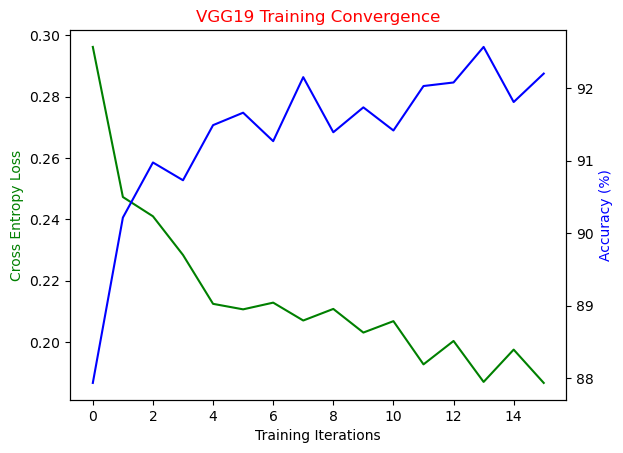

In [46]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("VGG19 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [47]:
torch.save(model.state_dict(), model_path2)

In [48]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True) 
model_temp.classifier = Sequential(
        *list(model_temp.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    ) 

model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [49]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.1541
	Accuracy: 94.59%
[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,

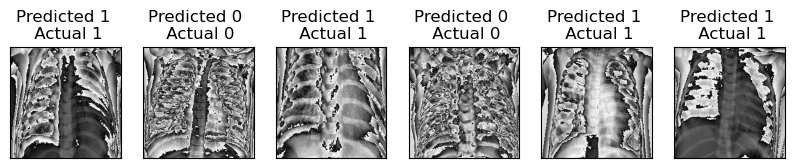

In [50]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [51]:
time_taken = toc-tic

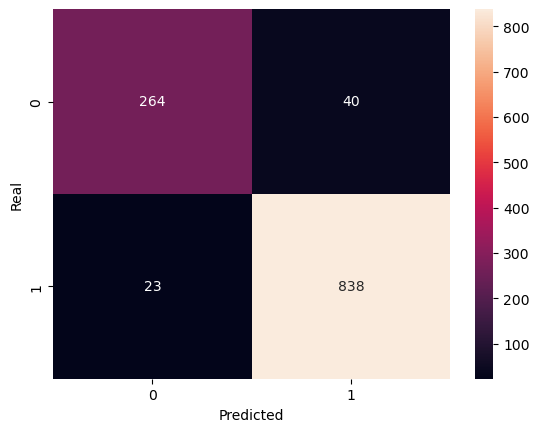

Time taken:  689.3808882236481
Test size: 1165
Total Accuracy:  0.9459227467811159
Total Precision:  0.9544419134396356
Total Recall:  0.9732868757259001
Total F1 Score:  0.9637722829212191
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       304
           1       0.95      0.97      0.96       861

    accuracy                           0.95      1165
   macro avg       0.94      0.92      0.93      1165
weighted avg       0.95      0.95      0.95      1165



In [52]:
valvgg = matrix_confusion(test_targets, pred_targets,time_taken)

In [53]:
out = pd.DataFrame([valvgg],
                   index = ['VGG19 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
VGG19 Model,689.380888,0.945923,0.954442,0.973287,0.963772


In [54]:
import pickle

In [55]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/vgg19.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# DenseNet 121

In [56]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.classifier.in_features
modelhead = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2) # 2 classes
)
model.classifier = modelhead
model = model.to('cuda')
print(model.classifier)

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


In [58]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [59]:
epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/densenet121 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


toc = time.time()

Training [6%]	Loss: 0.3231	Accuracy: 86.36%
Saving model with test loss of 90.532
Training [12%]	Loss: 0.2424	Accuracy: 90.53%
Training [19%]	Loss: 0.2240	Accuracy: 91.37%
Saving model with test loss of 91.734
Training [25%]	Loss: 0.2143	Accuracy: 91.73%
Saving model with test loss of 91.464
Training [31%]	Loss: 0.2123	Accuracy: 91.46%
Training [38%]	Loss: 0.2092	Accuracy: 91.76%
Saving model with test loss of 92.176
Training [44%]	Loss: 0.2023	Accuracy: 92.18%
Saving model with test loss of 92.200
Training [50%]	Loss: 0.2027	Accuracy: 92.20%
Training [56%]	Loss: 0.1951	Accuracy: 92.52%
Saving model with test loss of 92.593
Training [62%]	Loss: 0.1908	Accuracy: 92.59%
Training [69%]	Loss: 0.1840	Accuracy: 92.94%
Saving model with test loss of 92.740
Training [75%]	Loss: 0.1904	Accuracy: 92.74%
Saving model with test loss of 92.249
Training [81%]	Loss: 0.1943	Accuracy: 92.25%
Training [88%]	Loss: 0.1751	Accuracy: 93.06%
Saving model with test loss of 92.813
Training [94%]	Loss: 0.1867	A

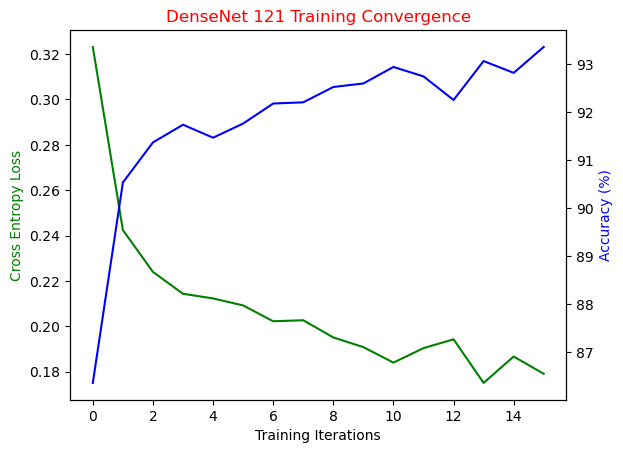

In [60]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("DenseNet 121 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [61]:
torch.save(model.state_dict(), model_path2)

In [62]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model_temp.classifier = modelhead
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [63]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.1380
	Accuracy: 95.97%
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,

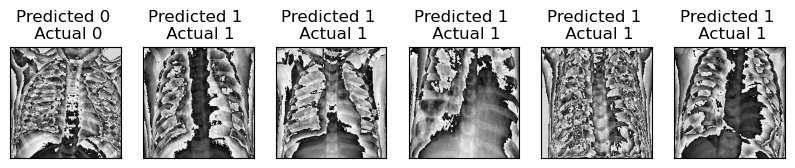

In [64]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [65]:
time_taken = toc-tic

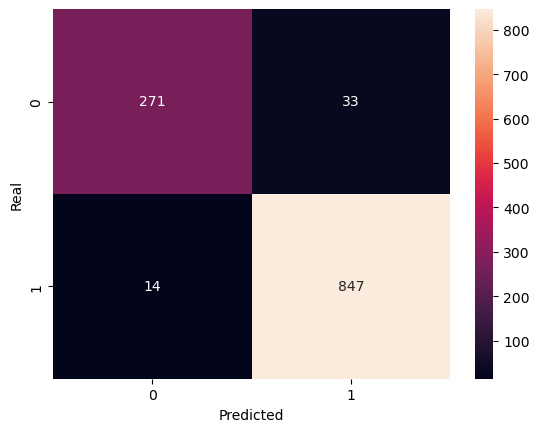

Time taken:  588.103437423706
Test size: 1165
Total Accuracy:  0.959656652360515
Total Precision:  0.9625
Total Recall:  0.983739837398374
Total F1 Score:  0.9730040206777715
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       304
           1       0.96      0.98      0.97       861

    accuracy                           0.96      1165
   macro avg       0.96      0.94      0.95      1165
weighted avg       0.96      0.96      0.96      1165



In [66]:
valdense = matrix_confusion(test_targets, pred_targets,time_taken)

In [67]:
out = pd.DataFrame([valdense],
                   index = ['DenseNet 121 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
DenseNet 121 Model,588.103437,0.959657,0.9625,0.98374,0.973004


In [68]:
import pickle

In [69]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/densenet121.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# EfficientNet

In [70]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [71]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.classifier)
classifier_indices = [i for i, layer in enumerate(model.classifier) if isinstance(layer, Linear)]
last_fc_index = classifier_indices[-1] if classifier_indices else None

# Define your custom model head
n_inputs = model.classifier[last_fc_index].in_features  # Number of input features for your new layers
modelhead = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2)  # 2 classes in the final output layer
)
model.classifier = Sequential(
        *list(model.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    )
    
print(model)
model = model.to('cuda')


Sequential(
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (squeeze): Flatten()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1280, out_features=1000, bias=True)
)
EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_featu

In [72]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [73]:
epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/effnetb0 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


toc = time.time()

Training [6%]	Loss: 0.3205	Accuracy: 86.66%
Saving model with test loss of 90.704
Training [12%]	Loss: 0.2307	Accuracy: 90.70%
Training [19%]	Loss: 0.2202	Accuracy: 91.46%
Saving model with test loss of 92.519
Training [25%]	Loss: 0.1921	Accuracy: 92.52%
Saving model with test loss of 92.666
Training [31%]	Loss: 0.1942	Accuracy: 92.67%
Training [38%]	Loss: 0.1741	Accuracy: 93.08%
Saving model with test loss of 93.427
Training [44%]	Loss: 0.1703	Accuracy: 93.43%
Saving model with test loss of 93.427
Training [50%]	Loss: 0.1678	Accuracy: 93.43%
Training [56%]	Loss: 0.1628	Accuracy: 93.55%
Saving model with test loss of 93.721
Training [62%]	Loss: 0.1529	Accuracy: 93.72%
Training [69%]	Loss: 0.1535	Accuracy: 93.99%
Saving model with test loss of 94.383
Training [75%]	Loss: 0.1389	Accuracy: 94.38%
Saving model with test loss of 94.310
Training [81%]	Loss: 0.1486	Accuracy: 94.31%
Training [88%]	Loss: 0.1458	Accuracy: 94.46%
Saving model with test loss of 94.898
Training [94%]	Loss: 0.1373	A

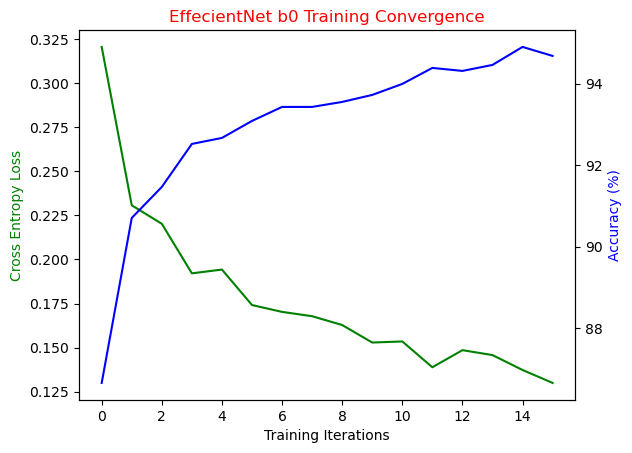

In [74]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("EffecientNet b0 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [75]:
torch.save(model.state_dict(), model_path2)

In [76]:
model_temp = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model_temp.classifier = Sequential(
        *list(model_temp.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    ) 
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [77]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.1104
	Accuracy: 95.62%
[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,

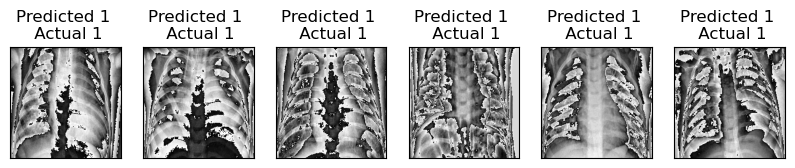

In [78]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [79]:
time_taken = toc-tic

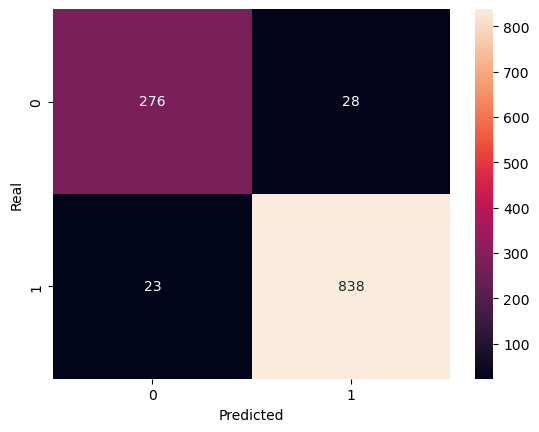

Time taken:  576.1691138744354
Test size: 1165
Total Accuracy:  0.9562231759656652
Total Precision:  0.9676674364896074
Total Recall:  0.9732868757259001
Total F1 Score:  0.9704690214244355
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       304
           1       0.97      0.97      0.97       861

    accuracy                           0.96      1165
   macro avg       0.95      0.94      0.94      1165
weighted avg       0.96      0.96      0.96      1165



In [80]:
valeff = matrix_confusion(test_targets, pred_targets,time_taken)

In [81]:
out = pd.DataFrame([valeff],
                   index = ['EfficientNet b0 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
EfficientNet b0 Model,576.169114,0.956223,0.967667,0.973287,0.970469


In [82]:
import pickle

In [83]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/effnetb0.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully
